
<div align="center"><img width="275" height="50" src="http://zillow.mediaroom.com/image/Zillow_Wordmark_Blue_RGB.jpg" /> </div> 

<div align="center"> <h1>Regression Project</h1> 
  <h6> by David Berchelmann -- March 24, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://cdn-assets-s3.streeteasy.com/assets/svg/footer-f3b296bd4be445e92b2d0fd4b1d3c1050d30933b14e76d7b2fcf8215bb01ba1a.svg" /> </div>

-----

-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my regression project focusing on Zillow. The dataset comes from a SQL database and can also be accessed via Kaggle.com. 

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/DBerchelmann/zillow_regression_project



----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- The company is needing to predict home values of single unit properties in the Southern California area that the tax district assesses. 

<h4><b>The Goal</b></h4>

- My goal is to develop a linear regression based machine learning model that can accurately predict home values of single unit properties based on data from May-August of 2017.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Create Recommendations Based On Findings 
  
<h4><b>The Findings</b></h4>

- My choice of model(polynomial regression) beats the baseline with an R^2 of 43% and an RMSE on the test data of 223,330 vs a baseline mean of 301,465.
 

- The bulk of the property data is for properties under $1.68 million dollars. my linear regression model begins to under value properties as the value increases over the upper threshold. 
    
- More refinement, feature creation, and data will be needed to create a more honed in prediction model.
    
    
 
-------

<h3><u>Visualization of Final Results:</u></h3>

<div align="center"><img width="800" height="50" src="https://i.ibb.co/PMY5NsP/poly-regressor.png/> </div>


----------


-------




<h3><u>Environment Setup</u></h3>

In [1]:
# packages for data analysis & mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import seaborn as sns
import plotly.express as px
from datetime import date 



# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing



# address warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prep, train, & explore functions
from wrangle import get_connection, new_zillow_data, get_zillow_data, clean_zillow, split_data, wrangle_zillow, train_validate_test, min_max_scale, get_object_cols, get_numeric_X_cols
from feature_engineer import select_kbest, rfe 
import explore
import evaluate



<h4> Data Validation </h4>

 - Before the data was brought in through the acquire file, I invenstigated it further in SQL. Below are a few of my findings:
     - Some properties were labeled as 'single family residential' but had a unit count of more than 1
     - There were a number of properties that lacked location info (zip, lat, long, fips), these will be dropped in prep
     - Bedrooms and Bathrooms both have rows that have a value of 0. This too wil be dealt with in the prep stage

---
<h3><u>Acquire the Data</u></h3>

----

In [2]:
df = get_zillow_data()

In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My original dataframe is coming in with 39696 rows and 16 columns.


In [4]:
df.isna().sum()

parcelid                            0
propertylandusetypeid               0
propertylandusedesc                 0
unitcnt                         14719
transactiondate                     0
calculatedfinishedsquarefeet      114
bedroomcnt                          0
bathroomcnt                         0
fips                                0
regionidzip                        27
yearbuilt                         137
taxvaluedollarcnt                   1
latitude                            0
longitude                           0
assessmentyear                      0
taxamount                           1
dtype: int64

<h4> <b>I'm interested in outliers within the tax appraised value (taxvaluedollarcnt) column. Let's investigate visually and with IQR.</b></h4>

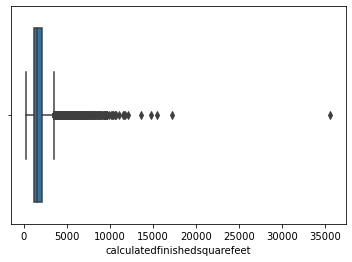

In [5]:
sns.boxplot(data = df, x = 'calculatedfinishedsquarefeet')
plt.show()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

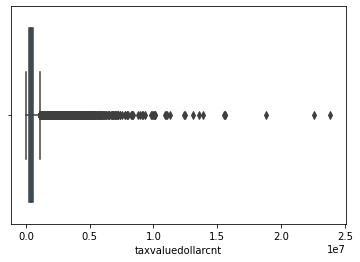

In [6]:
sns.boxplot(data = df, x = 'taxvaluedollarcnt')

In [7]:
q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

print(f'The upper bound quartile is {upperbound} sqft while our lower bound quartile is {lowerbound}. These outliers will be addressed in prep')

The upper bound quartile is 1679155.0 sqft while our lower bound quartile is -888592.0. These outliers will be addressed in prep


-----

<h3>Outlier Takeaway</h3>

- While there were outliers within square footage, it was found that there could be better accuracy with the model by not touching them and instead focusing on the outliers with tax appraised value. 
- The dataset only includes properties who have a tax assessed value of less than $1,680,000.00

-----

<h3>Other Takeaways From Acquire</h3>
- Used my get_zillow_data() function to bring the data from SQL using the query:

    ```
    SELECT parcelid, propertylandusetypeid, propertylandusedesc, unitcnt, 
                 transactiondate, calculatedfinishedsquarefeet, bedroomcnt, 
                 bathroomcnt, fips, regionidzip, yearbuilt, taxvaluedollarcnt, latitude, longitude,  
                 assessmentyear, taxamount 
                 FROM predictions_2017 
                 JOIN properties_2017 using (parcelid)\
                 JOIN propertylandusetype using (propertylandusetypeid) 
                 WHERE month(transactiondate) >= 05 and month(transactiondate) <= 08 
                 AND propertylandusetypeid > 250 
                 AND propertylandusetypeid < 280  
                 AND propertylandusetypeid != 270  
                 AND propertylandusetypeid != 271 
                 OR unitcnt = 1 
                 ORDER BY unitcnt DESC; 
                                                ``` 

- Running df.shape showed (62159 rows, 16 columns)
- There aren't a whole lot of nulls to filter out as this had been dealt with in SQL
     - Of the nulls that are present (minus unit count), they exist in:
         - completed square feet (119) 
         - year built (144)
         - regionid zip (36)
         - tax amount (4)
         - tax value dollar count (1)
     - These nulls will be handled in the prepare file
- The unit count column will be dropped so those nulls will not be an issue. It's purpose will be addressed in the prep stage
- Columns will be renamed for readability. These can be found in the data dictionary

     
 -----

----

<h3>Clean/Prep the Data</h3>

----

 - To clean the data, I will be utilizing the clean_zillow(df) function that is within the wrangle.py file
     - We will first look at the removal of outliers for the tax_assessed_value and find a distribution, while still right skewed, much less affected by high values outside the upper bound quartile.

In [8]:
df = clean_zillow(df)

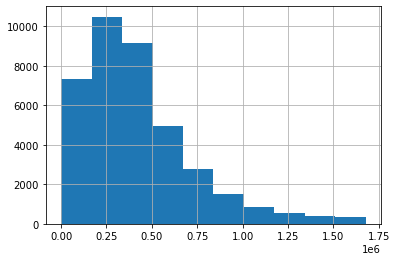

In [9]:
df.tax_assessed_value.hist()
plt.show()

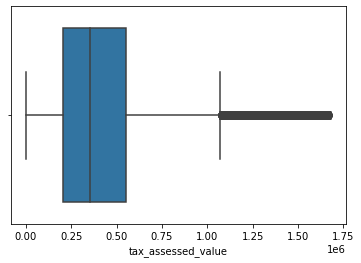

In [10]:
sns.boxplot(data = df, x = 'tax_assessed_value')
plt.show()

The following was done to prep the data. This is all heald within the ```clean_zillow``` function located in the ```wrangle.py``` file which is located in the github repository linked at the beginning of this notebook.

- Identify properties that do not qualify as single family homes
    
    
- Delete properties that do not qualify as single family homes
    
    
- Create new column (age_of_home)
    today = pd.to_datetime('today')
    df['age_of_home'] = today.year - df['yearbuilt']
    
               
- Remove NaNs from finished square feet
   
    
- Replace '0' bathrooms with the median which is 2
    
  
- Replace '0' bedrooms with the median which is 3
    

    
- Remove NaNs from zip code
    

- Remove NaNs from tax amount
    
  
- Remove NaNs from year_built
    
- Remove NaNs from tax value dollar count
  
- Remove decimal from latitude and longitude
   
- Convert latitude and longitude to positonal data points using lambda funtion (i.e. putting a decimal in the correct place)
   
- Remove properties with a unit count greater than 1
    
- Delete properties that do not qualify as single family homes
    
- Drop unitcnt column
    
- Remove properties with a tax value greater than or equal to 1.68 million dollars and sqfootage greater than 3500 (these are outliers causing issues)
    
- Convert age_of_home column from float to an integer (this removes the decimal point)
  
- Create bathrooms per sqft
    ``` df['bath_pers_qft'] = df['bathroomcnt'] / df['calculatedfinishedsquarefeet'] ```
    
- Create bedrooms per sqft
   ``` df['beds_pers_qft'] = df['bedroomcnt'] / df['calculatedfinishedsquarefeet']```
    
- Rename columns (new column name is after the colon (:))
  
     - 'parcelid':'parcelid'
     - 'propertylandusetypeid':'landuse_id'
     - 'propertylandusedesc':'landuse_desc'
     - 'transactiondate':'last_sold_date'
     - 'calculatedfinishedsquarefeet':'total_sqft'
     - 'bedroomcnt':'bedroom_quanity'
     - 'bathroomcnt':'bathroom_quanity',
     - 'fips':'fips'
     - 'regionidzip':'zip_code'
     - 'yearbuilt':'year_built'
     - 'taxvaluedollarcnt':'tax_assessed_value'
     - 'latitude':'latitude', 'longitude':'longitude',
     - 'assessmentyear':'tax_assess_yr'
     - 'taxamount':'property_tax'
     - 'age_of_home':'age_of_home'
     
   
- Set parcelid as the index
   
    
- drop un-needed columns
  - ```df.drop('landuse_id', axis=1, inplace=True)```
  -  ```df.drop('landuse_desc', axis=1, inplace=True)```
  -  ```df.drop('last_sold_date', axis=1, inplace=True)```
  -  ```df.drop('tax_assess_yr', axis=1, inplace=True)```
    

- convert columns to object
    
  -  ```df['zip_code'] = df['zip_code'].astype(object)```
  -  ```df['fips'] = df['fips'].astype(object)```
  -  ```df['year_built'] = df['year_built'].astype(object)```

-----
<h3> Prep Takeaways </h3>
    
   - This data set came in fairly messy with some NaNs (empty data), Mislabeled features (like a single family home showing as a 4 unit count property) and features like latitude and longitude that needed to be changed to their correct form.
   - Columns were renamed for ease of readbility 
   - Several new features (columns) were created
       - Age of home
       - Bathrooms Per Square Foot
       - Bedrooms Per Square Foot
   - There were three columns that had their data type changed from int to object. This was done to allow for scaling later on of numeric features
       
  - After the cleaning was complete, I used the split data set to transition the data into train, validate, & test dataframes
  
  -------

<h3><u>Data Dictionary</u></h3>



|   Feature      |  Data Type   | Description    |
| :------------- | :----------: | -----------: |
|  parcelid | int64   | Unique parcel identifier    |
| landuse_id     | float64 | Identifier for landuse type|
| landuse_desc   | object | Describes the type of landuse|
| last_sold_date  | object |transaction date of when property last sold|
|  total_sqft  | float64   | Total livable square footage    |
| bedroom_quanity    | float64 | count of bedrooms|
| bathroom_quanity   | float64 | count of bathrooms|
| fips  | object | Federal Information Processing Code (county code)|
|  zip_code | object   | 5 digit code used by US Postal Service    |
| year_built    | object | year home was built|
| tax_assesed_value   | float64 | total value of home established by taxing authority|
| latitude  | float64 | geographic coordinate that specifies the north–south position |
|  longitude  | float64   | geographic coordinate that specifies the east-west position     |
| tax_assess_yr    | float64 | The most recent year property taxes were assessed|
| property_tax   | float64 | ad valorem tax on the value of a property.|
| age_of_home  | int64 | age of home as of today's date in years|
| tax_rate    | float64 | This is property tax / tax_assessed_value|
| baths_pers_qft   | float64 | numbers of baths per sqft|
| beds_pers_qft  | float64| number of beds per sqft|


-----

<h3> Explore the Data </h3>

-----

<i>again, we will use functions from ```wrangle.py``` to clean our data, train/validate/test, & scale (on train data)</i>

In [11]:
df = wrangle_zillow()
train, validate, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'tax_assessed_value')

----

<h5>Let's examine a pairplot to get a better look at our quanitative variables</h5>

-----

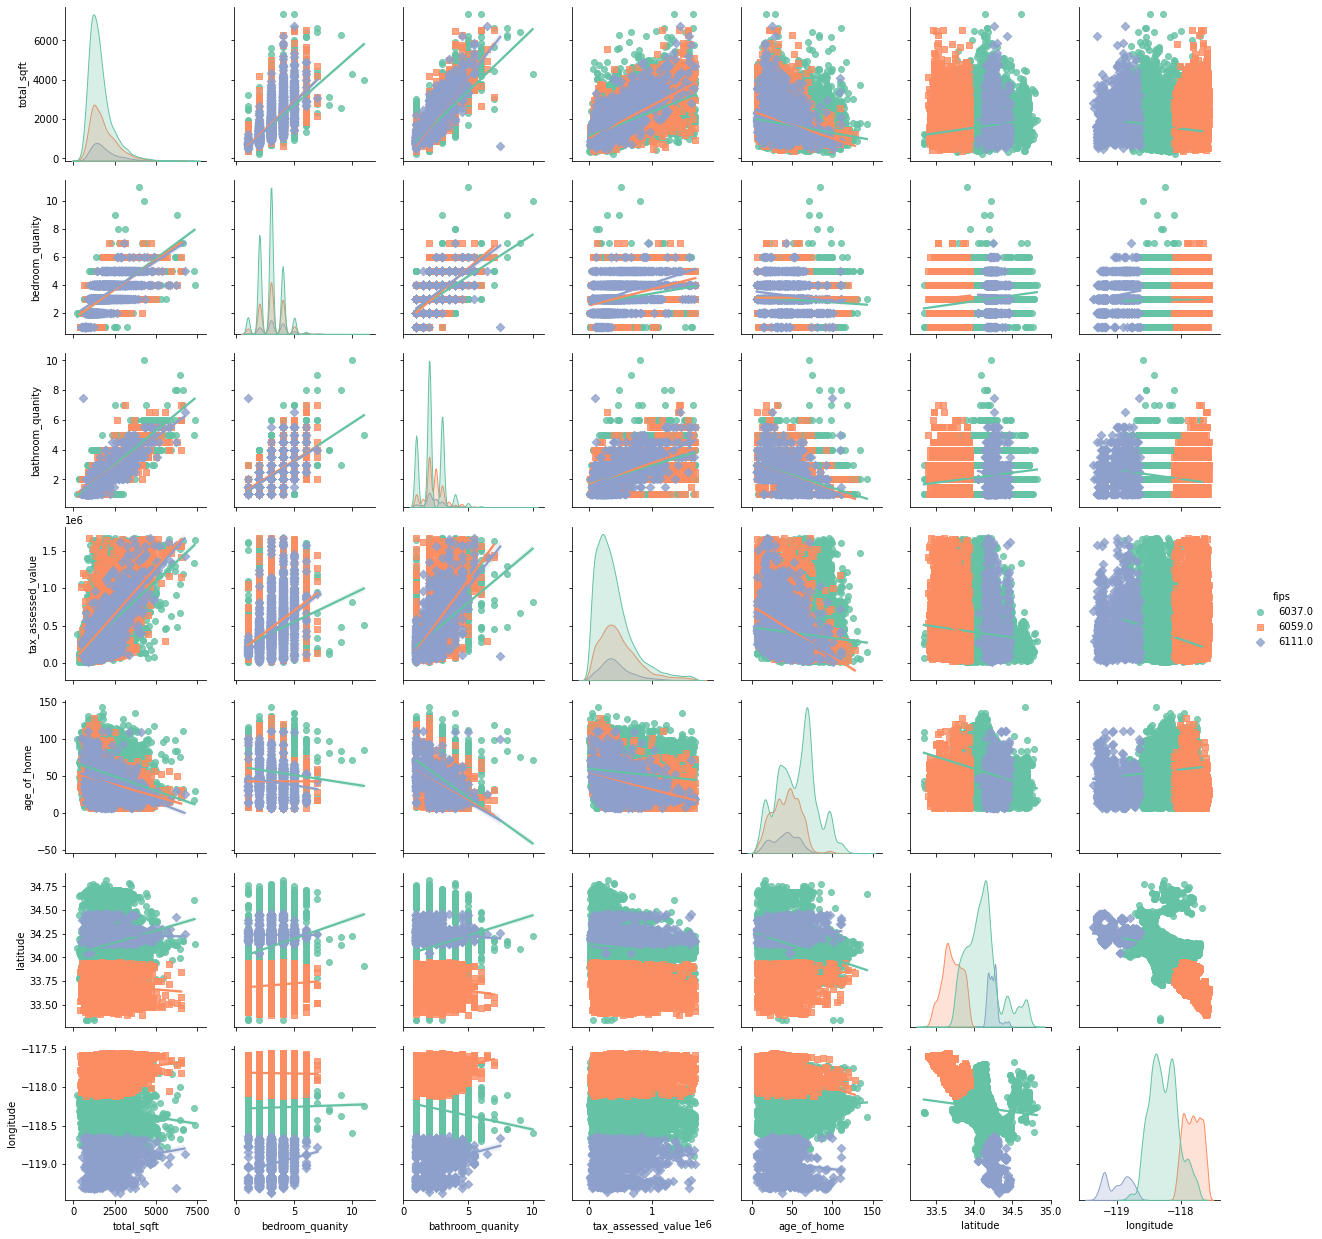

In [12]:
quant_vars = ['total_sqft', 'bedroom_quanity', 'bathroom_quanity', 'tax_assessed_value', 'age_of_home', 'latitude', 'longitude']
explore.plot_variable_pairs(train, quant_vars)

<h4>Pair Plot Takeaways</h4>

   - What stands out is that there looks to be definite correlation between total sqft/bedroom_quanity & sqft/bathroom_quanity
   - Tax assessed value seems to have the strongest correlation with bathroom_quanity and total_sqft
   - There is also a negative correlation between bathroom_quanity and age_of_home along with total_sqft & age of home
       - What this tells me is that older homes have less square footage and because of less space, they also had less bathrooms

----

<h4>Time For A Correlation Heat Map!</h4>

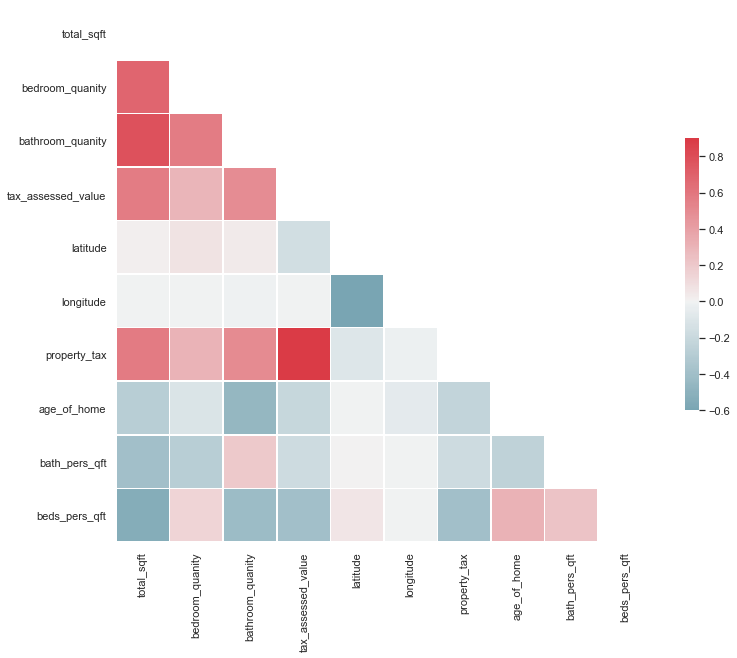

In [13]:
explore.corr_map(train)

<h4> Correlation Takeaways </h4>

 - Well, this heat map did a great job giving an additional visual of where our correlations exist. 
     - The darker the red, the stronger the postive correlation between variables. The darker the blue, the stronger the negative correlation between the two variables.
 - Time to run some correlation tests before looking at other data
 
<h4> Hypothesis Correlation Tests </h4>

In [14]:
# Set Confidence Interval and Alpha; check alpha.

confidence_interval = .95
alpha = round(1 - confidence_interval, 2)
a = round(1 - confidence_interval, 2)
print(f'alpha = {alpha}')

alpha = 0.05


Let's see if there is a relationship between bathrooms and total square feet like we saw above.
- <b>Null Hypothesis:</b> There is no relationship between bathroom quantity and total sqft.
- <b>Alternative Hypothesis:</b> There is a relationship between between bathroom quantity and total sqft.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.78


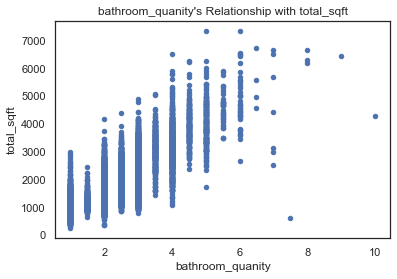

In [15]:
explore.correlation_exploration(train, 'bathroom_quanity', 'total_sqft')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bathrooms and total sqft.</h5>

-----

Let's see if there is a relationship between bathroom quantity and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between bathroom quantity and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between bathroom quantity and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.49


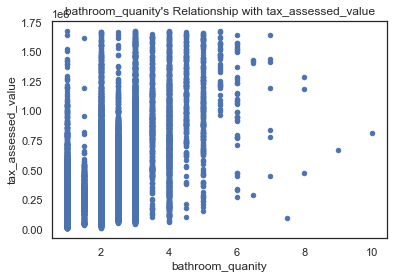

In [16]:
explore.correlation_exploration(train, 'bathroom_quanity', 'tax_assessed_value')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bathrooms and total sqft.</h5>

-----

Let's see if there is a relationship between total sqft and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between total sqft and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between total sqft and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.3


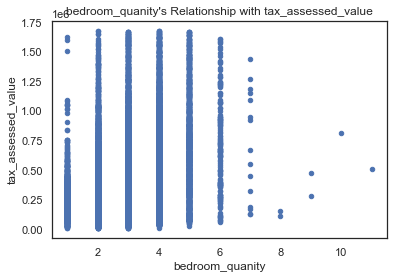

In [17]:
explore.correlation_exploration(train, 'bedroom_quanity', 'tax_assessed_value')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bedrooms and total sqft.</h5>

-----

Let's see if there is a relationship between latitude and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between latitude and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between latitude and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 1.666624267399106e-123 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = -0.16


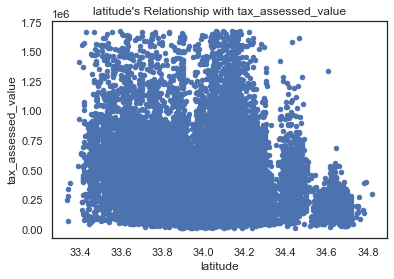

In [18]:
explore.correlation_exploration(train, 'latitude', 'tax_assessed_value')

Let's see if there is a relationship between latitude and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between longitude and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between longitude and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.8287487119874121 and we fail to reject the null hypothesis. There is 0.829% chance that we see these results by chance.
r = -0.0


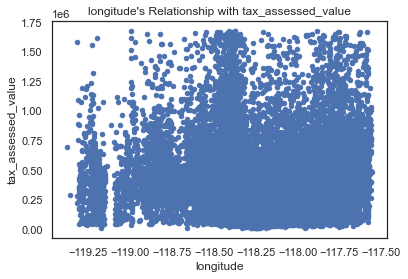

In [19]:
explore.correlation_exploration(train, 'longitude', 'tax_assessed_value')

----

<h4>Correlation Hypothesis Takeaways</h4>

- My big takeaway from the hypothesis testing is that while latitude is correlated with tax assessed value, longitude is not. This will be interesting to test out when we get to feature engineering and eventually modeling.
- The other items were all confirmed to be correlated after running a Pearson test. 

-----

<h3> Time for more charts! </h3>

 - Let's get a better look at the distriubtion of our plots in the Southern California area.
     - FIPS is a federal identifier for counties. 
        - 6037 - Los Angeles County, California
        - 6059 - Orange County, California
        - 6111 - Ventura County, California

<Figure size 864x864 with 0 Axes>

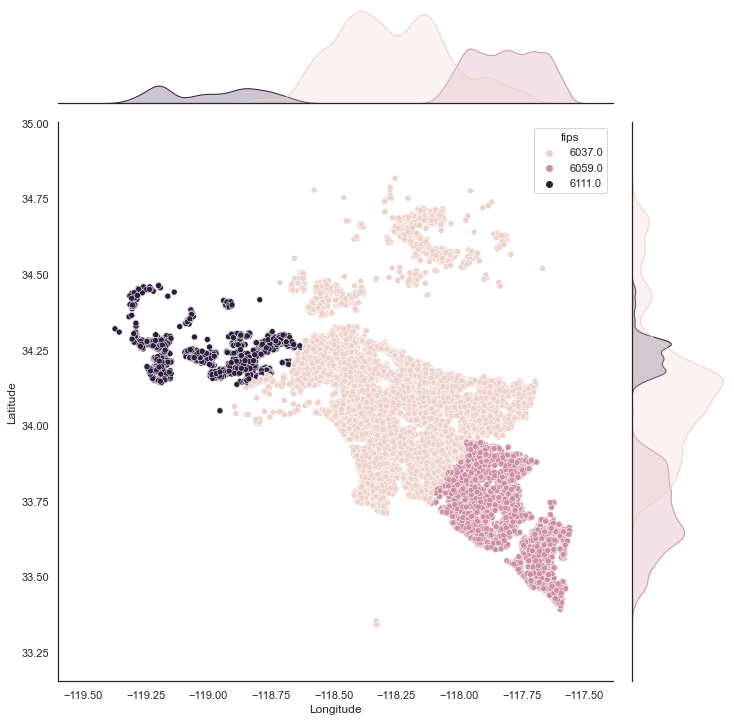

In [20]:
# exploratory analysis
# location distribution
plt.figure(figsize=(12,12))
fig=sns.jointplot(data = train, x=train.longitude.values, y=train.latitude.values, size=10, hue='fips')
fig.set_axis_labels('Longitude','Latitude')
#plt.colorbar(orientation="vertical",fraction=0.07)
plt.show()

 - While the above plot is nice to look at, I can give you a much better and more interactive visual for each data point

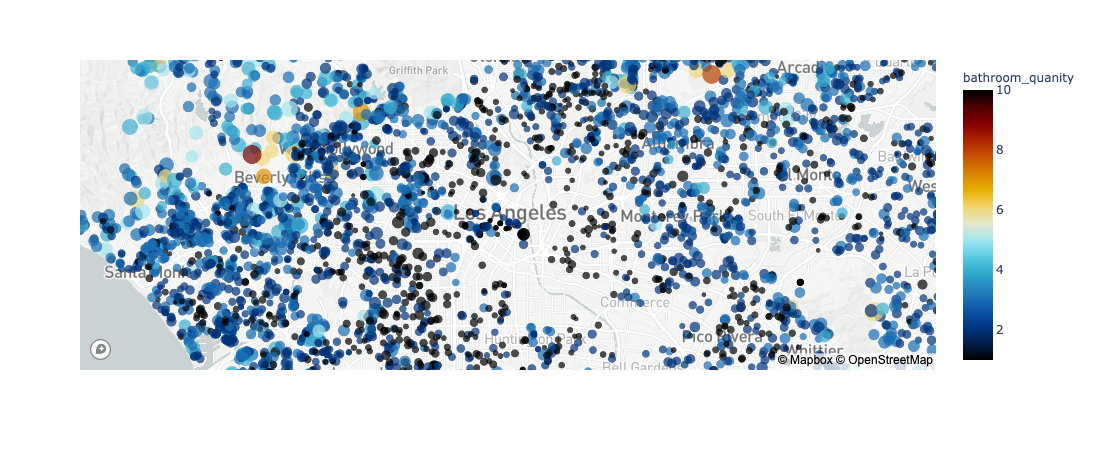

In [21]:
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(train, lat="latitude"  ,lon="longitude" , color="bathroom_quanity", size="total_sqft",
                        center={"lat": 34.0522, "lon": -118.2437},
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

There is a chance the above plot didn't show because of a plugin issue. So you can have a visual, see below. When interactive, you are able to zoom in all the way to the exact property and hover over it to get pertinent information. Size of the circle is determined by total_sqft and the color chart labels the bathrooms with black as 1 bathroom and dark red means near 10 bathrooms.

<div align="center"><img width="800" height="50" src="https://i.ibb.co/khhGQ5w/Interactive-Map.png" /> </div>

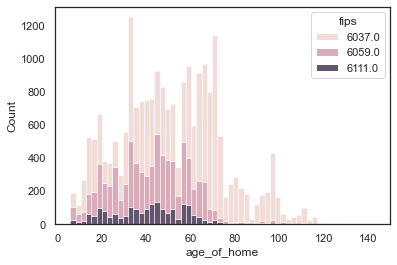

In [22]:
sns.histplot(data=train, x="age_of_home", hue = "fips", multiple="stack")
plt.show()

Los Angeles County has the majority of the data points and carries the oldest homes. Let's look at how this plays out with tax assessed value.

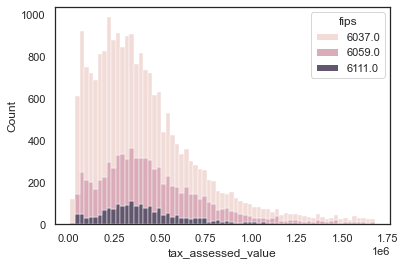

In [23]:
sns.histplot(data=train, x="tax_assessed_value", hue = "fips", multiple="stack")
plt.show()

Interestingly enough, the distributions are pracitaly the same shape with a difference being seen on the y-axis measuring number of data points in each county. 

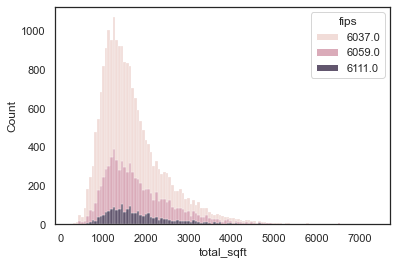

In [24]:
sns.histplot(data=train, x="total_sqft", hue = "fips", multiple="stack")
plt.show()

Wow, 1,500 sqft seems like a true sweet spot for the median square footage. Let's double check that

In [25]:
train.total_sqft.median()

1514.0

-------

<h3>Time for a T-Test</h3>
    
   - Since we have been looking at historgrams with county being a differentiator. Let's look into bathrooms per sqft and see if there is a difference between Los Angeles County and Orange County.
   
   ---

In [26]:
# Does Los Angeles County(6037) have more bathrooms per sqft than Orange County (6059)

null_hypothesis = "Los Angeles County does not have more bathrooms per sqft than Orange County"
alternative_hypothesis = "Los Angeles County does have more bathrooms per sqft than Orange County"
confidence_level = .95
alpha = 1 - confidence_level # call your shot before you run your test

In [27]:
la_fips = train[train.fips == 6037]
oc_fips = train[train.fips == 6059]

In [28]:
t, p = stats.ttest_ind(la_fips.bath_pers_qft, oc_fips.bath_pers_qft)
t, p

(4.8716021584011155, 1.1156287736623101e-06)

In [29]:
if (p/2) < a and t > 0:
    print("We reject the null hypothesis that", null_hypothesis) 
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Failing to reject the null != 'accepting the null'")

We reject the null hypothesis that Los Angeles County does not have more bathrooms per sqft than Orange County
We move forward with the alternative hypothesis that Los Angeles County does have more bathrooms per sqft than Orange County


----

<h3> Let's Scale the Data </h3>

----

In [30]:
object_cols = get_object_cols(df)
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [31]:
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

-------

<h3> Feature Engineering </h3>

----

In [32]:
def select_kbest(x, y, k):
    
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k=k)
    
    # find the top 8 X's correlated with y
    f_selector.fit(X_train_scaled, y_train)
    
    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()
    
    f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
    
    return f_feature

In [33]:
select_kbest(X_train_scaled,'tax_assessed_value', 4 )

['total_sqft', 'bathroom_quanity', 'property_tax', 'beds_pers_qft']

In [34]:
def rfe(x, y, k):
    
    lm = LinearRegression()
    
    rfe = RFE(lm, k)
    
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled,y_train)  
    
    mask = rfe.support_
    
    rfe_features = X_train_scaled.loc[:,mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    
    return  rfe_features

In [35]:
rfe(X_train_scaled, 'tax_assessed_value', 4)

4 selected features


['total_sqft', 'latitude', 'longitude', 'property_tax']

<h3> Takeaways</h3>

- I examined almost every iteration of feature use in the models. 
- What ended up getting me the highest R^2 was the use of all 6 features

----

<h3> Establish A Baseline</h3>

----

- Before we move forward and establish our baseline, we need to drop property tax from our X_Train, ..Validate, & ..Test. This is because property tax is a part of tax appraised value and its inclusion would skew results in modeling. 

- Also to note is that when we are doing feature engineering, this is where we would add/take away columns when we want to get the best result

In [36]:
X_train_scaled = X_train_scaled.drop(columns=['property_tax'])
X_validate_scaled = X_validate_scaled.drop(columns=['property_tax'])
X_test_scaled = X_test_scaled.drop(columns=['property_tax'])

Now we create the baseline with the following:

---

In [37]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict IM_pred_mean
tax_assessed_value_pred_mean = y_train.tax_assessed_value.mean()
y_train['tax_assessed_value_pred_mean'] = tax_assessed_value_pred_mean
y_validate['tax_assessed_value_pred_mean'] = tax_assessed_value_pred_mean

# 2. compute IM_pred_median
tax_assessed_value_pred_median = y_train.tax_assessed_value.median()
y_train['tax_assessed_value_pred_median'] = tax_assessed_value_pred_median
y_validate['tax_assessed_value_pred_median'] = tax_assessed_value_pred_median


# 3. RMSE of IM_pred_mean
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of IM_pred_median
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  303861.61 
Validate/Out-of-Sample:  301465.29
RMSE using Median
Train/In-Sample:  311334.09 
Validate/Out-of-Sample:  311334.09


---
<h5>For this modeling, we are going to use the RMSE mean since it was the lowest between it and the median</h5>

---

<h3> Linear Regression Model </h3>

In [38]:
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train_scaled, y_train.tax_assessed_value)

# predict train
# 
# use the thing!
# 
y_train['tax_assessed_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_assessed_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  235203.55971999452 
Validation/Out-of-Sample:  236165.64617183316


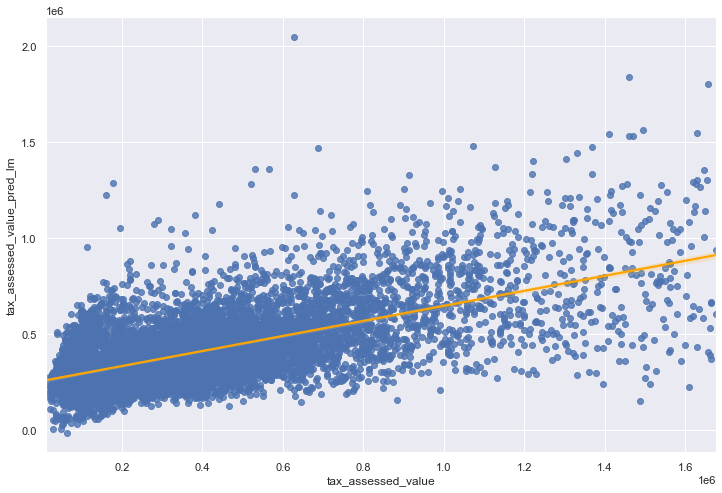

In [40]:
plt.figure(figsize=(12, 8))
sns.set_style('darkgrid')
sns.regplot( x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lm, line_kws={"color": "orange"}, 
             label="Model: LinearRegression")
plt.show()

----

<h3> Lasso-Lars </h3>

----

In [41]:
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train_scaled, y_train.tax_assessed_value)

# predict train
y_train['tax_assessed_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_assessed_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  235208.26907388956 
Validation/Out-of-Sample:  236188.17093490963


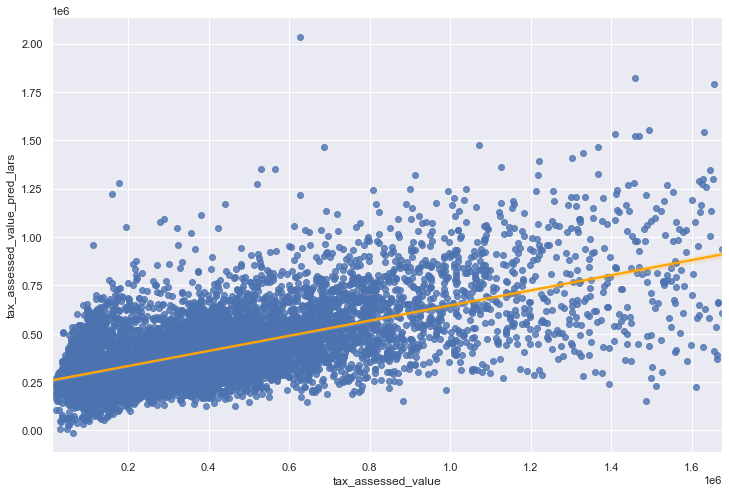

In [42]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.regplot( x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lars, line_kws={"color": "orange"}, 
             label="Model: LinearRegression")
plt.show()

----

<h3>Tweedie Regressor</h3>

----

In [43]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_assessed_value)

# predict train
y_train['tax_assessed_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_assessed_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  237924.6541764283 
Validation/Out-of-Sample:  237924.6541764283


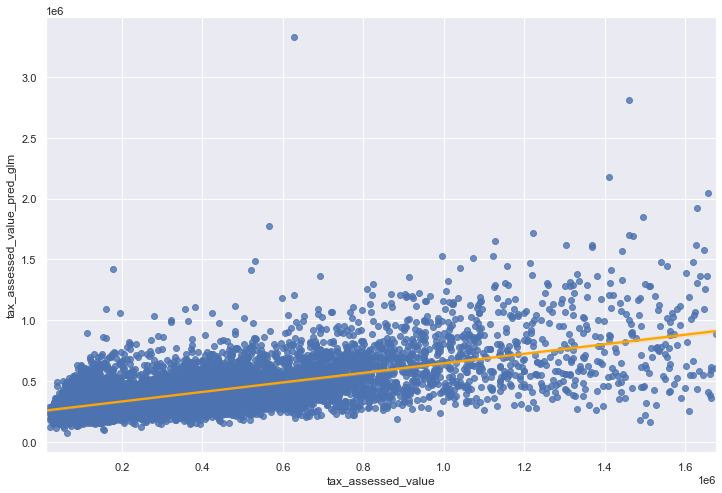

In [44]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.regplot( x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_glm, line_kws={"color": "orange"}, 
             label="Model: LinearRegression")
plt.show()

<h3>Polynomial Regressor</h3>

In [45]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)

In [46]:
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_assessed_value)

# predict train
y_train['tax_assessed_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_assessed_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  228040.8628183017 
Validation/Out-of-Sample:  228920.7729641509


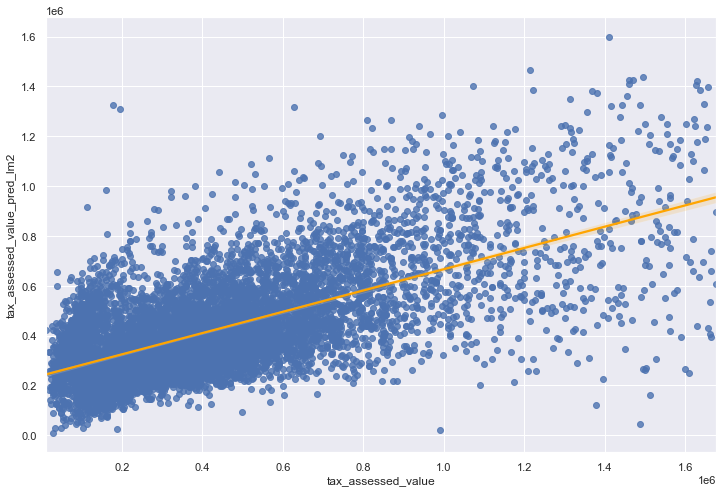

In [47]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.regplot( x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lm2, line_kws={"color": "orange"}, 
             label="Model: LinearRegression")

plt.show()

<h3>Time to Visualize Our Models</h3>

Text(0.5, 1.0, 'Model: Polynomial Regresser')

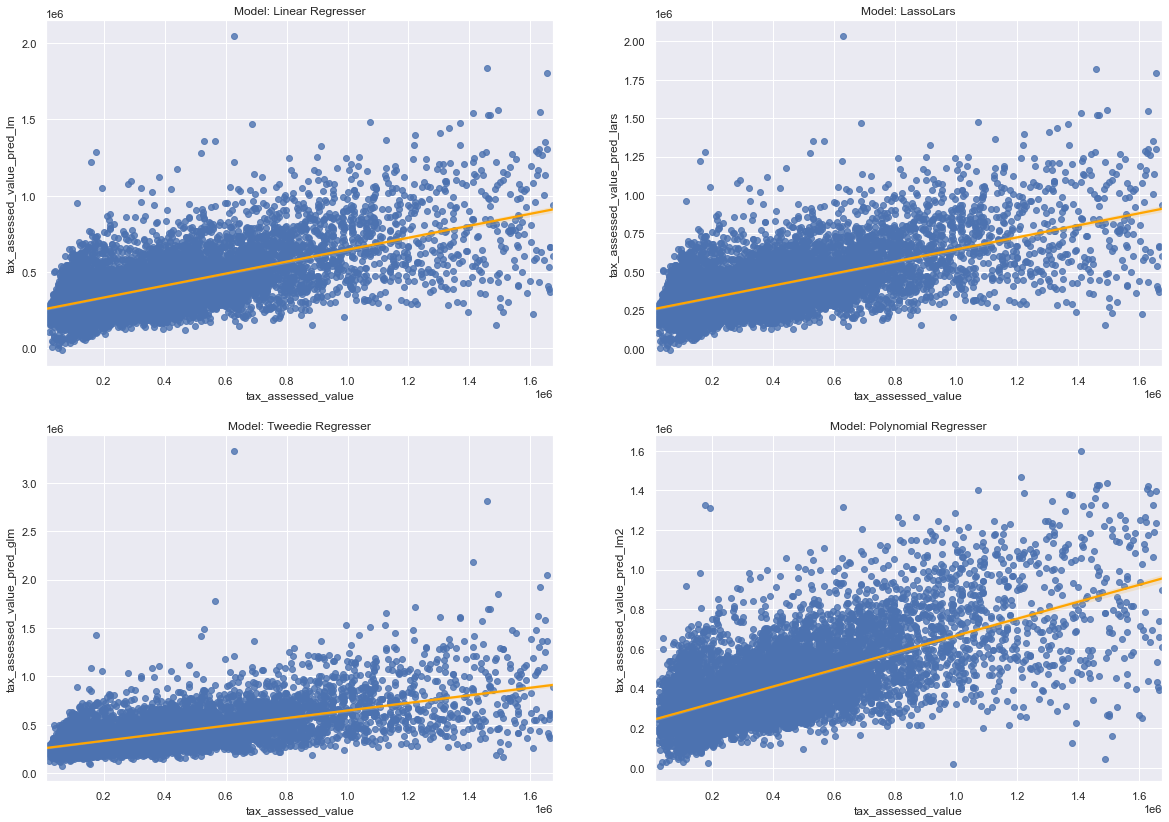

In [48]:
plt.subplots(2, 2, figsize=(20, 14), sharey=True)
sns.set(style="darkgrid")
plt.subplot(2,2,1)
sns.regplot(x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lm, line_kws={"color": "orange"})
plt.title("Model: Linear Regresser")

plt.subplot(2,2,2)
sns.regplot(x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lars, line_kws={"color": "orange"})
plt.title("Model: LassoLars")

plt.subplot(2,2,3)
sns.regplot(x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_glm, line_kws={"color": "orange"})
plt.title("Model: Tweedie Regresser")

plt.subplot(2,2,4)
sns.regplot(x= y_validate.tax_assessed_value, y= y_validate.tax_assessed_value_pred_lm2, line_kws={"color": "orange"}) 
plt.title("Model: Polynomial Regresser")

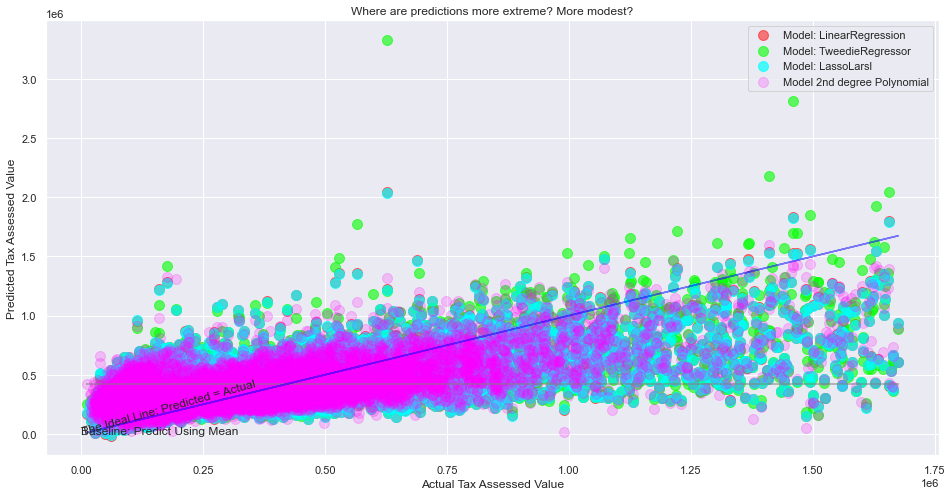

In [49]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_assessed_value, y_validate.tax_assessed_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_glm, 
            alpha=.6, color="lime", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lars, 
            alpha=.7, color="cyan", s=100, label="Model: LassoLarsl")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm2, 
            alpha=.2, color="magenta", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Assessed Value")
plt.ylabel("Predicted Tax Assessed Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

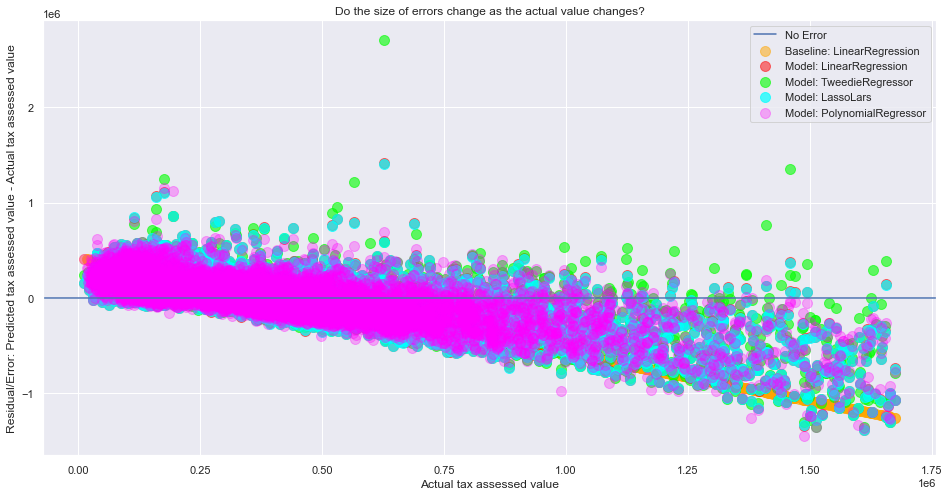

In [59]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
ax.grid(linestyle='-', linewidth='0.25', color='grey')

plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_mean - y_validate.tax_assessed_value , 
            alpha=.5, color="orange", s=100, label="Baseline: LinearRegression")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm - y_validate.tax_assessed_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_glm - y_validate.tax_assessed_value, 
            alpha=.6, color="lime", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lars - y_validate.tax_assessed_value , 
            alpha=.7, color="cyan", s=100, label="Model: LassoLars")
plt.scatter(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm2 - y_validate.tax_assessed_value , 
            alpha=.3, color="magenta", s=100, label="Model: PolynomialRegressor")



plt.legend()
plt.xlabel("Actual tax assessed value")
plt.ylabel("Residual/Error: Predicted tax assessed value - Actual tax assessed value")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

In [ ]:
fig = px.scatter(
    train, y_validate.tax_assessed_value,  y_validate.tax_assessed_value_pred_lm2 - y_validate.tax_assessed_value,
    marginal_y='violin',
    trendline='ols'
)
fig.show()

<h3> Choose Our Test model </h3>

I have chosen the polynomial regression as the model to go with as it has the lowest numbers. Lasso Lars would also be acceptable but I see it as more of fielders choice at this juncture.

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_assessed_value_pred_lm2'] = lm2.predict(X_test_degree2)

#X_test_scaled
# evaluate: rmse

rmse_test = mean_squared_error(y_test.tax_assessed_value, y_test.tax_assessed_value_pred_lm2) ** (1/2)

print("RMSE for Linear Regression Model using Polynomial\nOut-of-Sample Performance: ", rmse_test)

----

<h3> R^2 for the Linear Regressor Model </h3>

In [ ]:
r2_score(y_train.tax_assessed_value, y_train.tax_assessed_value_pred_lm2)

In [ ]:
r2_score(y_validate.tax_assessed_value, y_validate.tax_assessed_value_pred_lm2)

In [ ]:
r2_score(y_test.tax_assessed_value, y_test.tax_assessed_value_pred_lm2)

------

<h3>Takeaways From the Modeling</h3>

- As the value of the home increases, the model has a more difficult time predicting the value since the bulk of the data set is 1.5 million and less) As the assessed value increases, the model begins to undervalue the home more.

- While all the models performed admiralby well and beat the baseline, Polynomial Regressor did the best..

- We looked at multiple features. The best set up, after doing feature engineering was:


     1.   bedroom_quanity   
     2.   bathroom_quanity  
     3.   latitude          
     4.   longitude         
     5.   age_of_home       
     6.   bath_pers_qft    
     7.   beds_pers_qft
     
- All of our models beat the baseline which is what was needed. When testing the linear regression model on out of sample data, it performed well and even beat the R^2 of the valid by almost .5%. 


<h3>Conclusions & Thoughts Moving Forward</h3>

There is a lot more work that can be done on this data set and more exploring, refinement, and creation of special features is highly recommended. 

While we did beat the baseline at nearly 40%, that number is still not high enough to get an accurate read of home prices across these three counties. A step in the right direciton was taken but the work is just beginning.

-------------

<h1>Tax Rate Distributions By County</h1>

In [51]:
tax_df = clean_zillow(df)

In [52]:
tax_df['tax_rate'] = round(((tax_df['property_tax'] / tax_df['tax_assessed_value'])* 100),2)

In [53]:
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38320 entries, 13083743 to 14319797
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_sqft          38320 non-null  float64
 1   bedroom_quanity     38320 non-null  float64
 2   bathroom_quanity    38320 non-null  float64
 3   fips                38320 non-null  object 
 4   zip_code            38320 non-null  object 
 5   year_built          38320 non-null  object 
 6   tax_assessed_value  38320 non-null  float64
 7   latitude            38320 non-null  float64
 8   longitude           38320 non-null  float64
 9   property_tax        38320 non-null  float64
 10  age_of_home         38320 non-null  int64  
 11  bath_pers_qft       38320 non-null  float64
 12  beds_pers_qft       38320 non-null  float64
 13  tax_rate            38320 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 4.4+ MB


In [54]:
tax_df.groupby('fips').tax_rate.median()

fips
6037.0    1.25
6059.0    1.16
6111.0    1.12
Name: tax_rate, dtype: float64

In [55]:
tax_df.groupby('fips').tax_assessed_value.median()

fips
6037.0    325215.5
6059.0    417076.5
6111.0    386023.5
Name: tax_assessed_value, dtype: float64

------
<h3>Takeaways From Tax Rate Groupby</h3>


    - Median tax rates are lowest for Ventura County(6111) at 1.12 while they are highest in Los Angeles County(6037) with 1.25%. 
    - Median tax appraised value is highest in Orange County(6059) while Los Angeles County has the lowest Median value

[(0.0, 4.0)]

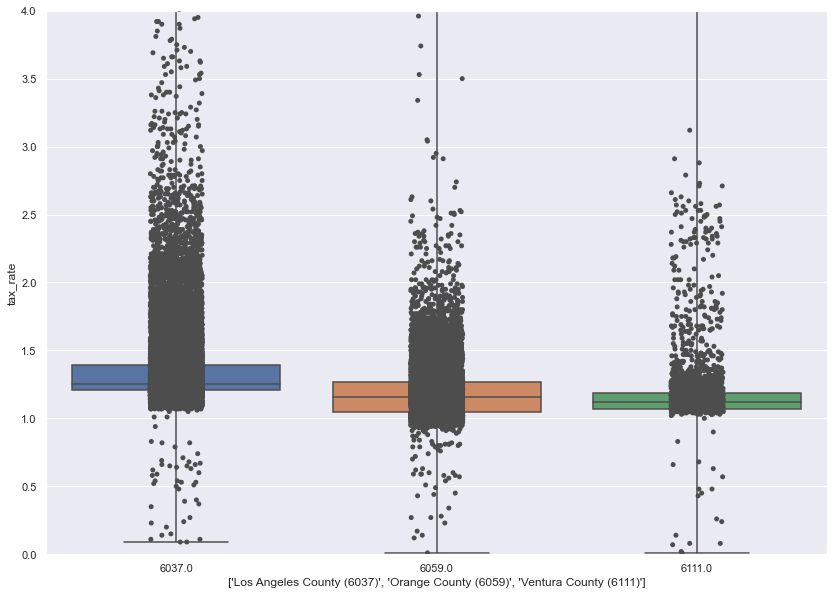

In [56]:


plt.figure(figsize=(14,10))



ax = sns.boxplot(x="fips", y="tax_rate", data=tax_df, whis=np.inf)
ax = sns.stripplot(x="fips", y="tax_rate", data=tax_df, color=".3")
ax.set_xlabel(['Los Angeles County (6037)', 'Orange County (6059)', 'Ventura County (6111)'])

ax.set(ylim=(0, 4))

------
<h3>Takeaways From Graph</h3>


   - A bulk of the tax rates are distributed from 1% to 2.35%
   - Los Angeles County has the most data point while Ventura has the least
   - Orange County is right in the middle

(0.75, 2.0)

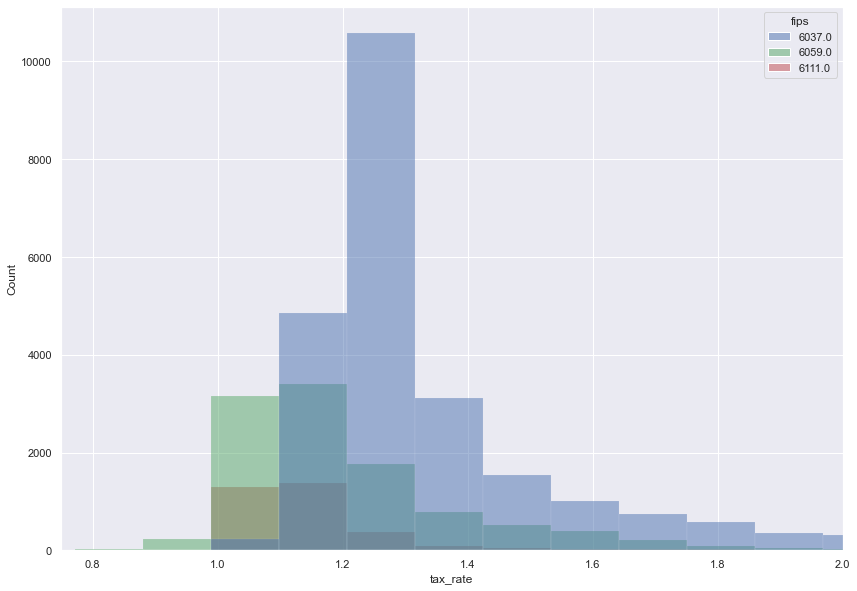

In [57]:
plt.figure(figsize=(14,10))
sns.histplot(data=tax_df, x="tax_rate", hue="fips",kde = False, bins = 750,  palette={6037:'b', 6059:'g', 6111:'r'})

plt.xlim(.75, 2)

In [58]:
tax_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38320 entries, 13083743 to 14319797
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_sqft          38320 non-null  float64
 1   bedroom_quanity     38320 non-null  float64
 2   bathroom_quanity    38320 non-null  float64
 3   fips                38320 non-null  object 
 4   zip_code            38320 non-null  object 
 5   year_built          38320 non-null  object 
 6   tax_assessed_value  38320 non-null  float64
 7   latitude            38320 non-null  float64
 8   longitude           38320 non-null  float64
 9   property_tax        38320 non-null  float64
 10  age_of_home         38320 non-null  int64  
 11  bath_pers_qft       38320 non-null  float64
 12  beds_pers_qft       38320 non-null  float64
 13  tax_rate            38320 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 5.6+ MB
